## Setup Environment and Dependencies

Import essential libraries for file operations, numerical computing, plotting, and deep learning, then configure logging to suppress verbose TensorFlow messages.


In [4]:
# Imports and Logging Configuration

import os
import pathlib
import logging
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel(logging.ERROR)

## Define Constants and Download Data Directories

Set hyperparameters such as batch size, image dimensions, epochs, and random seed; then define paths for training and testing datasets and allowed image extensions, after downloading the dataset from kaggle


In [6]:
# Constants and Directory Setup
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS = 50
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123

dataset_path = kagglehub.dataset_download("shrunmayshinde/road-obstacles-detection")

task_dir = pathlib.Path(dataset_path)
train_dir = task_dir / 'Training_Dataset'
test_dir = task_dir / 'Testing_Dataset'

# Valid image extensions
VALID_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}

100%|████████████████████████████████████████| 522M/522M [07:52<00:00, 1.16MB/s]

Extracting files...


## Collect and Validate Image Paths

Define a helper to walk directories, collect valid image file paths and labels, then apply it to training and test sets, validate images, and split training data into training and validation subsets.


In [7]:
# Helper to collect only valid image paths + labels
def collect_image_paths_and_labels(root_dir):
    """Walks subdirectories, returns (paths, labels) skipping unsupported files."""
    class_names = sorted([p.name for p in root_dir.iterdir() if p.is_dir()])
    paths, labels = [], []
    for idx, cname in enumerate(class_names):
        for img_path in (root_dir / cname).rglob('*'):
            if img_path.suffix.lower() in VALID_EXTS:
                # skip zero‐byte or unreadable
                try:
                    if img_path.stat().st_size > 0 and os.access(img_path, os.R_OK):
                        paths.append(str(img_path))
                        labels.append(idx)
                except:
                    continue
    return paths, labels, class_names

# collect for train+val and test
train_paths, train_labels, class_names = collect_image_paths_and_labels(train_dir)
test_paths, test_labels, _ = collect_image_paths_and_labels(test_dir)
num_classes = len(class_names)
print(f"Classes detected: {class_names}")
print(f"Found {len(train_paths)} train images, {len(test_paths)} test images")

def validate_images(paths):
    """Validate that all images can be read and decoded."""
    valid_paths = []
    invalid_files = []
    for path in paths:
        try:
            img_raw = tf.io.read_file(path)
            img = tf.io.decode_image(img_raw, channels=3, expand_animations=False)
            if img.shape[2] == 3:  # Check if image has 3 channels
                valid_paths.append(path)
            else:
                invalid_files.append((path, "Image does not have 3 channels"))
        except Exception as e:
            invalid_files.append((path, str(e)))
    return valid_paths, invalid_files

# Validate and filter images before proceeding
print("\nValidating training images...")
valid_train_paths, invalid_train = validate_images(train_paths)
if invalid_train:
    print("\nInvalid training images found:")
    for path, error in invalid_train:
        print(f"Path: {path}")
        print(f"Error: {error}\n")
    print(f"Total invalid training images: {len(invalid_train)}")
    print(f"Valid training images: {len(valid_train_paths)}")

print("\nValidating test images...")
valid_test_paths, invalid_test = validate_images(test_paths)
if invalid_test:
    print("\nInvalid test images found:")
    for path, error in invalid_test:
        print(f"Path: {path}")
        print(f"Error: {error}\n")
    print(f"Total invalid test images: {len(invalid_test)}")
    print(f"Valid test images: {len(valid_test_paths)}")

# Update labels to match valid paths
train_labels = [label for path, label in zip(train_paths, train_labels) if path in valid_train_paths]
test_labels = [label for path, label in zip(test_paths, test_labels) if path in valid_test_paths]

# Update paths to only include valid ones
train_paths = valid_train_paths
test_paths = valid_test_paths

# split train→train/val
np.random.seed(SEED)
perm = np.random.permutation(len(train_paths))
val_size = int(0.2 * len(train_paths))
val_idx, train_idx = perm[:val_size], perm[val_size:]
train_paths_split = [train_paths[i] for i in train_idx]
train_labels_split = [train_labels[i] for i in train_idx]
val_paths_split   = [train_paths[i] for i in val_idx]
val_labels_split   = [train_labels[i] for i in val_idx]

Classes detected: ['Normal', 'Potholes', 'SpeedBumps']
Found 1702 train images, 440 test images

Validating training images...

Invalid training images found:
Path: /Users/yael/.cache/kagglehub/datasets/shrunmayshinde/road-obstacles-detection/versions/1/Training_Dataset/Normal/189.jpg
Error: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 

Path: /Users/yael/.cache/kagglehub/datasets/shrunmayshinde/road-obstacles-detection/versions/1/Training_Dataset/Normal/30.highway-401-westbound-collectors-crash.jpg
Error: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 

Path: /Users/yael/.cache/kagglehub/datasets/shrunmayshinde/road-obstacles-detection/versions/1/Training_Dataset/Normal/201.jpg
Error: {{function_node __wrapped__DecodeImag

## Decode and Preprocess Images

Implement a robust function to read, decode, resize, and normalize images, with error handling to return default tensors on failure.


In [8]:
# Robust decoding + preprocessing fn, using tf.io.decode_image
def decode_and_preprocess(path, label):
    try:
        # Read raw bytes
        img_raw = tf.io.read_file(path)
        # Try to decode any supported format (jpeg/png/gif/bmp)
        img = tf.io.decode_image(img_raw, channels=3, expand_animations=False)
        # Make sure the shape info is set so resizing works
        img.set_shape([None, None, 3])
        # Resize & normalize
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        img = img / 255.0
        return img, label
    except tf.errors.InvalidArgumentError as e:
        print(f"Error processing image: {path}")
        print(f"Error details: {str(e)}")
        # Return a default image and label to allow the pipeline to continue
        return tf.zeros([IMG_HEIGHT, IMG_WIDTH, 3]), label
    except Exception as e:
        print(f"Unexpected error processing image: {path}")
        print(f"Error details: {str(e)}")
        return tf.zeros([IMG_HEIGHT, IMG_WIDTH, 3]), label

## Build Data Pipelines

Create TensorFlow datasets for training, validation, and testing, applying decoding, optional augmentation, caching, batching, and prefetching, while ignoring errors.


In [9]:
# Build tf.data pipelines with ignore_errors()
from tensorflow.data.experimental import ignore_errors

def make_ds(paths, labels, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(paths), seed=SEED)
    ds = ds.map(decode_and_preprocess, num_parallel_calls=AUTOTUNE)
    # skip any element where decode_or_preprocess raised an op error
    ds = ds.apply(ignore_errors())
    if augment:
        aug = keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_paths_split, train_labels_split, shuffle=True, augment=True)
val_ds   = make_ds(val_paths_split,   val_labels_split)
test_ds  = make_ds(test_paths,        test_labels)

# Build tf.data pipelines (redefinition without ignore_errors for comparison)
def make_ds(paths, labels, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.shuffle(len(paths), seed=SEED) if shuffle else ds
    ds = ds.map(decode_and_preprocess, num_parallel_calls=AUTOTUNE)
    if augment:
        aug = keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_paths_split, train_labels_split, shuffle=True, augment=True)
val_ds   = make_ds(val_paths_split,   val_labels_split)
test_ds  = make_ds(test_paths,        test_labels)

## Compute Class Weights

Calculate balanced class weights to address class imbalance during training.


In [10]:
# Optional class weights
all_train_labels = np.array(train_labels_split)
class_weights = compute_class_weight("balanced",
                                     classes=np.arange(num_classes),
                                     y=all_train_labels)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 0.9702898550724638, 1: 0.7095919448860626, 2: 1.7853333333333334}


## Build and Compile the Model

Set up a transfer learning model using MobileNetV2 as the backbone, add pooling and dense layers, and compile with optimizer, loss function, and evaluation metrics.


In [11]:
# Model: Transfer Learning w/ MobileNetV2 backbone
base_model = keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax'),
])
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Initial Training

Train the model on the prepared training dataset with validation, using the computed class weights.


In [12]:
# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights
)

Epoch 1/50
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.3872 - loss: 1.6823

KeyboardInterrupt: 

## Fine-Tuning the Model

Unfreeze a portion of the base model, lower the learning rate, and continue training to fine-tune pre-trained weights.


In [9]:
# Fine‐tune
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS+10,
    initial_epoch=history.epoch[-1],
    class_weight=class_weights
)

Epoch 50/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 483ms/step - accuracy: 0.7912 - loss: 0.7110 - val_accuracy: 0.8922 - val_loss: 0.2993
Epoch 51/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 465ms/step - accuracy: 0.8791 - loss: 0.2929 - val_accuracy: 0.8623 - val_loss: 0.4367
Epoch 52/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 471ms/step - accuracy: 0.9078 - loss: 0.2193 - val_accuracy: 0.8473 - val_loss: 0.5070
Epoch 53/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 490ms/step - accuracy: 0.9341 - loss: 0.1707 - val_accuracy: 0.8383 - val_loss: 0.5389
Epoch 54/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 492ms/step - accuracy: 0.9482 - loss: 0.1253 - val_accuracy: 0.8473 - val_loss: 0.5407
Epoch 55/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 491ms/step - accuracy: 0.9633 - loss: 0.1009 - val_accuracy: 0.8353 - val_loss: 0.5486
Epoch 56/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 499ms/step - accuracy: 0.9653 - loss: 0.0879 - val_accuracy: 0.8533 - val_loss: 0.5271
Epoch 57/60
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 526ms/step - accuracy: 0.9642 - loss: 0.0852 - 

## Evaluate on Test Set

Assess the trained model on the test dataset, output loss and accuracy, then generate a classification report and confusion matrix.


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.8487 - loss: 0.5146
Test accuracy: 88.84%
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.82      0.89       124
    Potholes       0.99      0.84      0.91       162
  SpeedBumps       0.77      1.00      0.87       144

    accuracy                           0.89       430
   macro avg       0.91      0.89      0.89       430
weighted avg       0.91      0.89      0.89       430



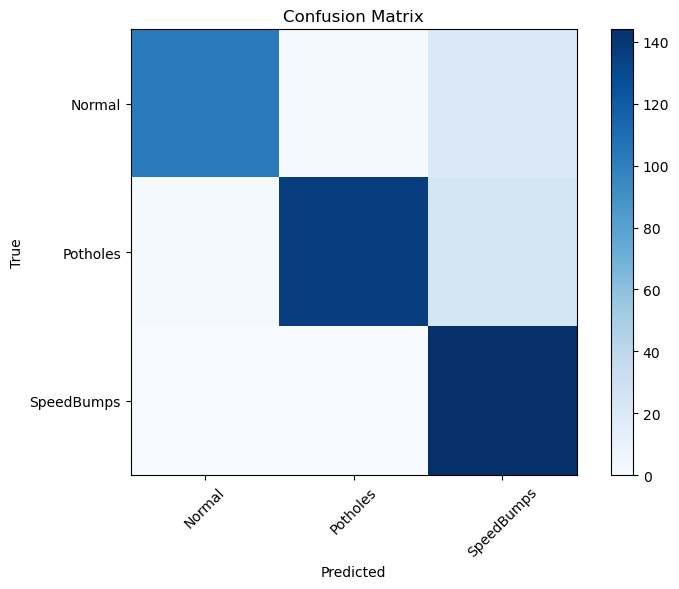

In [10]:
# Evaluate on test
loss, acc = model.evaluate(test_ds)
print(f"Test accuracy: {acc:.2%}")

# aggregate predictions
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(num_classes), class_names, rotation=45)
plt.yticks(range(num_classes), class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Plot Training and Validation Metrics

Visualize training and validation accuracy and loss over epochs to monitor model performance over time.


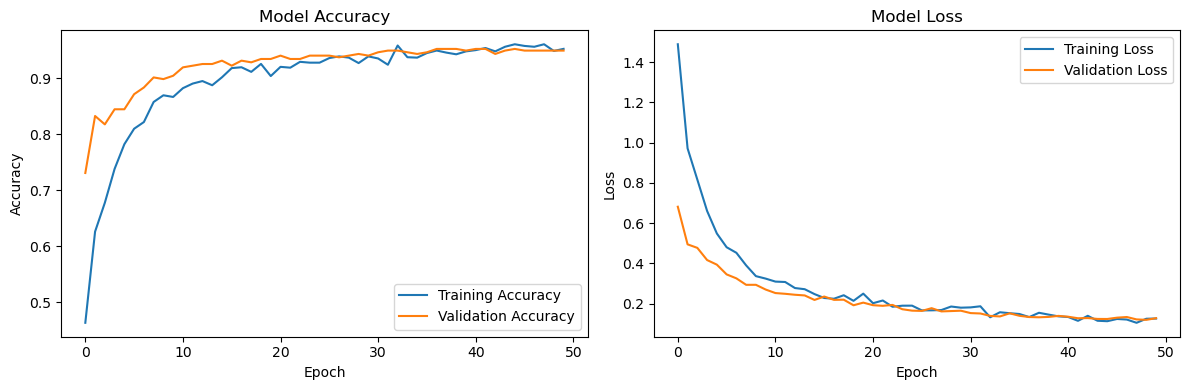

In [11]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Enhanced Confusion Matrix with Percentages

Display the confusion matrix annotated with both raw counts and percentage of predictions per true class.


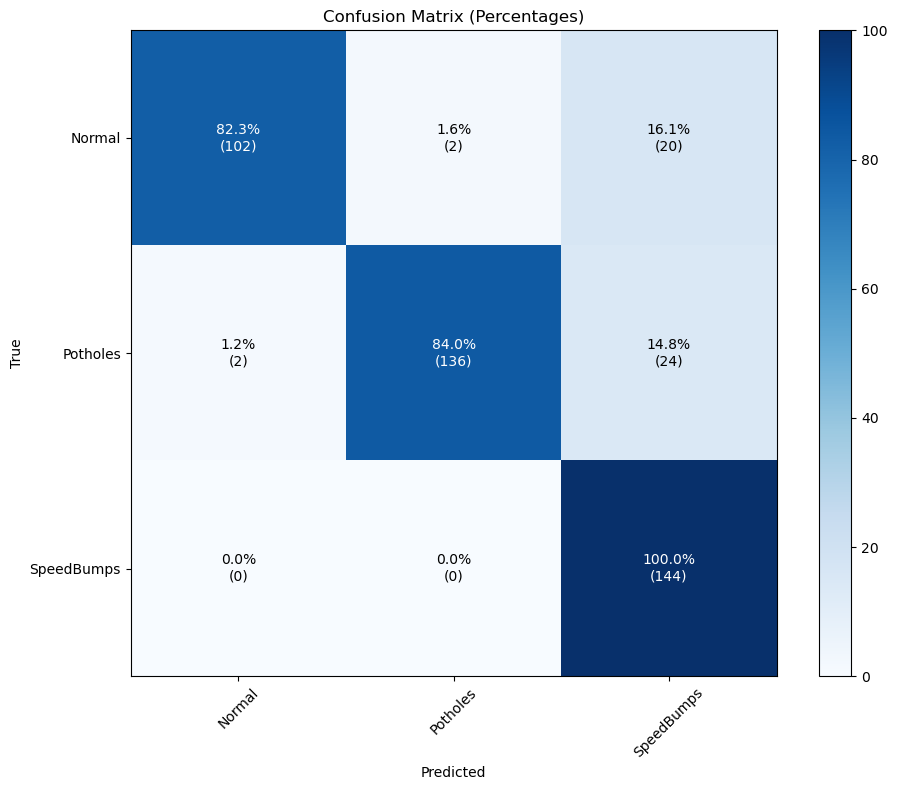

In [12]:
# Enhanced confusion matrix with percentages
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Percentages)')
plt.colorbar()

# Add text annotations
thresh = cm_percentage.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f'{cm_percentage[i, j]:.1f}%\n({cm[i, j]})',
                ha="center", va="center",
                color="white" if cm_percentage[i, j] > thresh else "black")

plt.xticks(range(num_classes), class_names, rotation=45)
plt.yticks(range(num_classes), class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Plot Correct vs Incorrect Predictions

Create a bar chart comparing the number of correct versus incorrect model predictions on the test set.


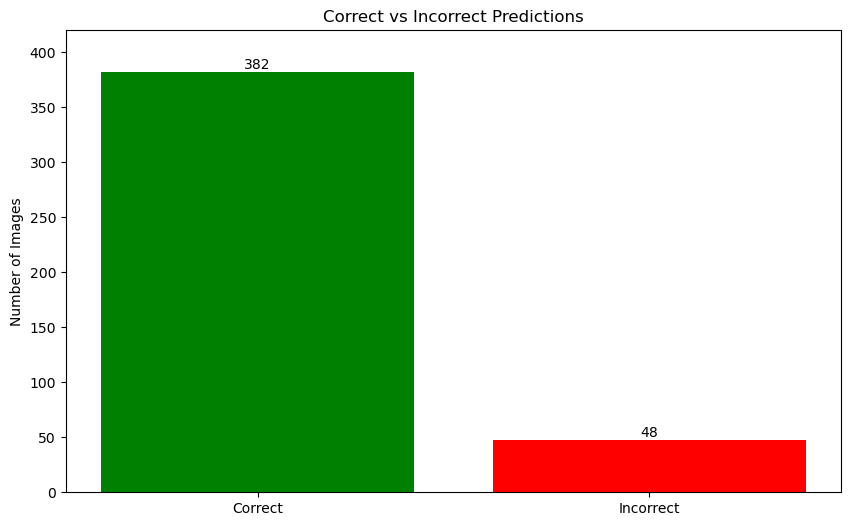

In [13]:
# Plot correct vs incorrect predictions
correct_preds = (y_true == y_pred)
incorrect_preds = ~correct_preds

plt.figure(figsize=(10, 6))
plt.bar(['Correct', 'Incorrect'], 
        [np.sum(correct_preds), np.sum(incorrect_preds)],
        color=['green', 'red'])
plt.title('Correct vs Incorrect Predictions')
plt.ylabel('Number of Images')
plt.ylim(0, max(np.sum(correct_preds), np.sum(incorrect_preds)) * 1.1)

# Add count labels on top of bars
for i, v in enumerate([np.sum(correct_preds), np.sum(incorrect_preds)]):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

## Plot Class-wise Accuracy

Compute the accuracy for each class and visualize it as a bar chart to identify per-class performance.


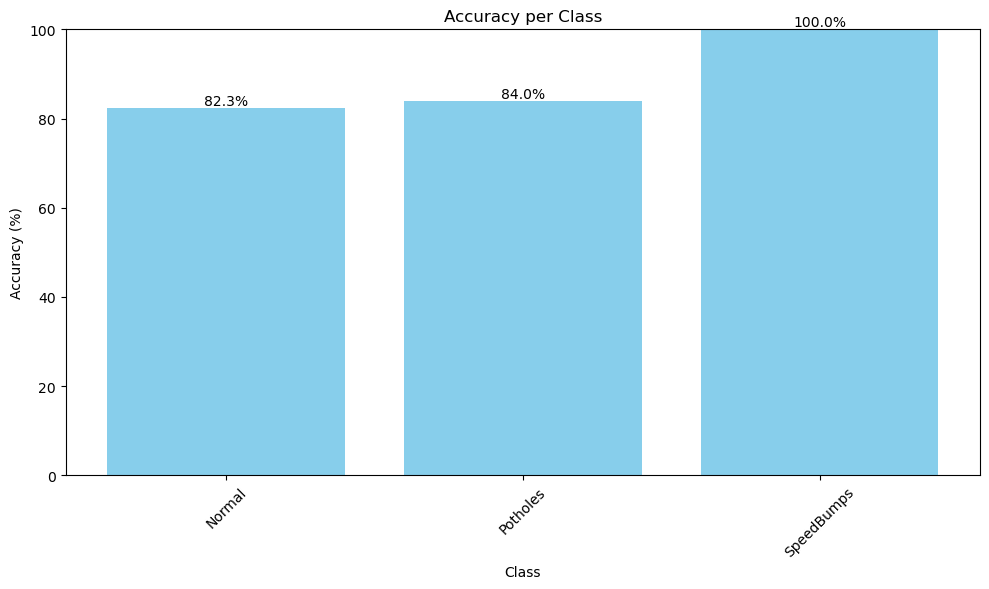

In [14]:
# Plot class-wise accuracy
class_accuracies = []
for i in range(num_classes):
    class_mask = (y_true == i)
    if np.sum(class_mask) > 0:  # Avoid division by zero
        accuracy = np.mean(y_pred[class_mask] == y_true[class_mask])
        class_accuracies.append(accuracy * 100)
    else:
        class_accuracies.append(0)

plt.figure(figsize=(10, 6))
plt.bar(class_names, class_accuracies, color='skyblue')
plt.title('Accuracy per Class')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# Add percentage labels on top of bars
for i, v in enumerate(class_accuracies):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()